# Assignment 2.2 - Gaussian Mixture Model - GMM

Please submit your solution of this notebook in the Whiteboard at the corresponding Assignment entry as .ipynb-file and as .pdf. <br><br>
Please do **NOT** rename the file!

#### State both names of your group members here:
[Jane and John Doe]

In [1]:
# Daniel Thompson and Paola Gega

## Grading Info/Details - Assignment 2.2:

The assignment will be graded semi-automatically, which means that your code will be tested against a set of predefined test cases and qualitatively assessed by a human. This will speed up the grading process for us.

* For passing the test scripts: 
    - Please make sure to **NOT** alter predefined class or function names, as this would lead to failing of the test scripts.
    - Please do **NOT** rename the files before uploading to the Whiteboard!

* **(RESULT)** tags indicate checkpoints that will be specifically assessed by a human.

* You will pass the assignment if you pass the majority of test cases and we can at least confirm effort regarding the **(RESULT)**-tagged checkpoints per task.

## Task 2.2.1 - GMMs

GMMs are a probabilistic model for representing normally distributed subpopulations within an overall population. They assume that the data is generated from a mixture of several Gaussian distributions with unknown parameters. The goal is to estimate the parameters of these Gaussian distributions (mean, covariance) and the mixing coefficients.

* Implement the GMM logic using the class structure below. The GMM class should be able to fit to data using the EM algorithm. **(RESULT)**
* Visualize the performance of your GMM implementation on synthetic data, i.e., generate data from known Gaussian distributions and show how well your GMM can recover the original parameters. **(RESULT)**

In [2]:
import numpy as np
# from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [3]:
class GMM:
    """
    Gaussian Mixture Model implementation using Expectation-Maximization algorithm.
    Assumes diagonal covariance matrices for simplicity.
    """
    def __init__(self, n_components, max_iter=100, tol=1e-4, random_state=None, silent=False):
        """
        Initialize EM clusterer for a GMM.
        
        Parameters:
        -----------
        n_components : int
            Number of clusters
        max_iters : int
            Maximum number of iterations
        tol : float
            Tolerance for convergence (change in centroids)
        random_state : int or None
            Random seed for reproducibility
        silent : bool
            Flag to silence output
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.silent = silent
        
        self.weights = None  # set mixing weights pi_k
        self.means = None    # set means of Gaussian components mu_k
        self.covariances = None # covariance matrices (sigma_k)

    def _initialize_parameters(self, X):
        """Initialize model parameters randomly."""
        n_samples, n_features = X.shape
        
        # uniformly initialised weights
        self.weights = np.ones(self.n_components) / self.n_components
        
        # randomly select data points to initialise means
        rng = np.random.default_rng(seed=self.random_state)
        random_indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]
        
        # covariances initialised as identity matrices (for simplicity) scaled by data variance
        data_var = np.var(X, axis=0)
        self.covariances = np.array([np.diag(data_var) for _ in range(self.n_components)])
        # for 1-D data, make sure covariance is a scalar or a 1x1 matrix
        if n_features == 1:
            self.covariances = np.array([np.array([v]) for v in data_var])

    def _e_step(self, X):
        """Expectation step: compute responsibilities for each data point and cluster"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # for all components K, calculate the probabilities of X belonging to that component
            try:
                pdf = multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
                responsibilities[:, k] = self.weights[k] * pdf
            except np.linalg.LinAlgError:
                # if covariance matrix is singular assign a very small probability to recover
                responsibilities[:, k] = 1e-10

        # calculate unconditional probability of x
        row_sums = np.sum(responsibilities, axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-10 # prevent division by zero if a row sums to 0
        # make them probabilities
        responsibilities = responsibilities / row_sums
        
        return responsibilities

    def _m_step(self, X, responsibilities):
        """Maximisation step: update mixture parameters"""
        n_samples, n_features = X.shape
        
        # calculate Nk: the total responsibility for each component
        Nk = np.sum(responsibilities, axis=0)
        
        # update mixture weights (pi_k)
        self.weights = Nk / n_samples
        
        # update means mu_k by calculating the weighted average of data points
        for k in range(self.n_components):
            self.means[k] = np.dot(responsibilities[:, k], X) / Nk[k]
        
        # update covariance matrices sigma_k by calculating the weighted outer product of differences
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k, np.newaxis] * diff
            cov_k = np.dot(diff.T, weighted_diff) / Nk[k]
            
            # to ensure numerical stability and prevent singularity, add a small term to the diagonal
            regularization = 1e-6 * np.eye(n_features)
            self.covariances[k] = cov_k + regularization

    def fit(self, X):
        """Fit GMM to data using EM algorithm."""
        self._initialize_parameters(X)
        
        log_likelihood_old = -np.inf
        
        for i in range(self.max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            
            # calculate log-likelihood for convergence check
            log_likelihood_new = self._compute_log_likelihood(X, responsibilities)
            
            # check for convergence
            if abs(log_likelihood_new - log_likelihood_old) < self.tol:
                print(f"Converged after {i+1} iterations.")
                break
            log_likelihood_old = log_likelihood_new
            
            if (i + 1) % 10 == 0 and (not self.silent): # print progress every 10 iterations
                print(f"Iteration {i+1}/{self.max_iter}, Log-Likelihood: {log_likelihood_new:.4f}")
        else:
            print(f"Reached max iterations ({self.max_iter}).")

    def _compute_log_likelihood(self, X, responsibilities):
        """Compute the log-likelihood of the data given the current model."""
        # log-likelihood: sum of the log of the marginal probability of each data point, P(x) = sum_k(pi_k * N(x | mu_k, sigma_k))
        
        n_samples = X.shape[0]
        log_likelihood = 0
        for i in range(n_samples):
            # calculate the marginal probability for data point X[i] by summing over its conditional probabilities under the K components
            marginal_prob = np.sum([
                self.weights[k] * multivariate_normal.pdf(X[i], mean=self.means[k], cov=self.covariances[k])
                for k in range(self.n_components)
            ])
            # add log of marginal probability to total log-likelihood; add small term to avoid log(0)
            log_likelihood += np.log(marginal_prob + 1e-9)
        return log_likelihood

    def predict(self, X):
        """
        Predict the component label for each sample.
        Assigns each sample to the component with the highest responsibility.
        """
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

Iteration 10/200, Log-Likelihood: -2296.2606
Iteration 20/200, Log-Likelihood: -2296.2061
Converged after 25 iterations.


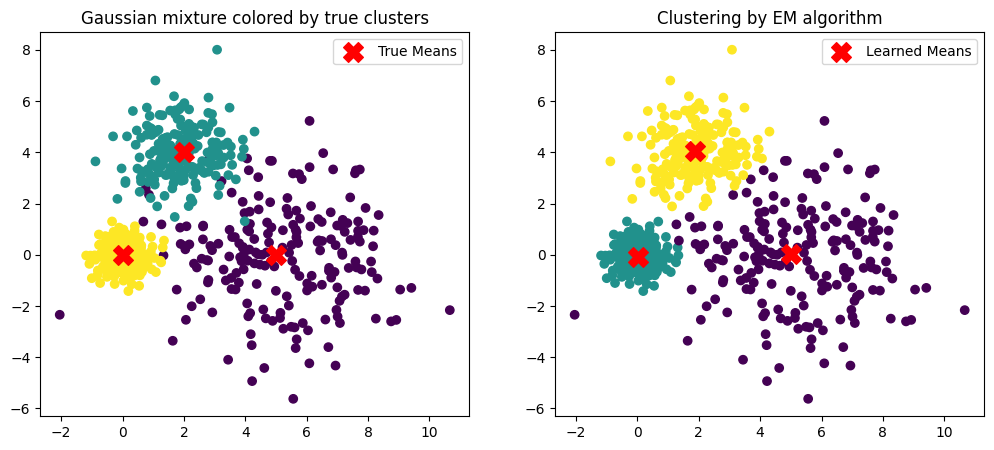

Learned weights: [0.34606443 0.330304   0.32363157]
Learned covariances: [[[ 4.30647142 -0.38599113]
  [-0.38599113  4.0175883 ]]

 [[ 0.238073   -0.00774212]
  [-0.00774212  0.25679428]]

 [[ 0.82356136  0.07363761]
  [ 0.07363761  0.94028451]]]


In [4]:
# Generate some synthetic 2-dimensional data
# Roughly recreating the example from the handout of Dr. Hagemann
X = np.vstack((np.random.multivariate_normal((5,0), [[4, 0], [0, 4]], 200),
               np.random.multivariate_normal((2,4), [[.9, 0], [0, .9]], 200),
               np.random.multivariate_normal((0,0), [[.25, 0], [0, .25]], 200)))
true_labels = np.zeros(600, dtype=int)
true_labels[200:400] = 1
true_labels[400:] = 2
true_means = np.array([[5,0],[2,4],[0,0]])

plot_1 = plt.subplot(1, 2, 1)
plt.subplots_adjust(bottom=0.1, right=1.6, top=0.9)
plt.scatter(X[:, 0], X[:, 1], c=true_labels)
plt.scatter(true_means[:, 0], true_means[:, 1], c='red', s=200, marker='X', label='True Means')
plt.title("Gaussian mixture colored by true clusters")
plt.legend()

# Run EM clusterer on the data
gmm = GMM(n_components=3, max_iter=200, random_state=69)
gmm.fit(X)
# Predict cluster assignments
labels = gmm.predict(X)

plot_2 = plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X', label='Learned Means')
plt.title("Clustering by EM algorithm")
plt.legend()
plt.show()

print("Learned weights:", gmm.weights)
print("Learned covariances:", gmm.covariances)

**Report:** The clusters are reconstructed very closely (up to a permutation of the labels). The only points not correctly classified were basically outliers anyway.  In this case, the mixture weights and covariance matrices were learned quite well also.  However, there seems to be more variation in how accurately the covariance matrices are approximated, likely due to the distribution of samples in the areas where our three Gaussian distributions overlap.

Now let's check the convergence when trying to take different numbers of clusters.

Testing with K=2
Converged after 25 iterations.
Testing with K=4
Reached max iterations (200).


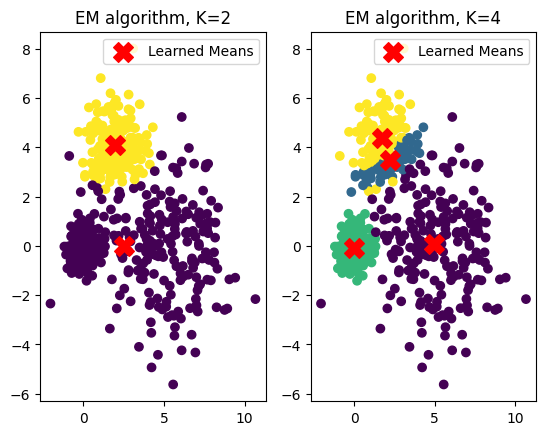

In [ ]:
# Run EM clusterer on the data
print("Testing with K=2:")
gmm = GMM(n_components=2, max_iter=200, silent=True)
gmm.fit(X)
# Predict cluster assignments
labels = gmm.predict(X)

plot_1 = plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X', label='Learned Means')
plt.title("EM algorithm, K=2")
plt.legend()

# Run EM clusterer on the data
print("Testing with K=4:")
gmm = GMM(n_components=4, max_iter=200, silent=True)
gmm.fit(X)
# Predict cluster assignments
labels = gmm.predict(X)

plot_2 = plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(gmm.means[:, 0], gmm.means[:, 1], c='red', s=200, marker='X', label='Learned Means')
plt.title("EM algorithm, K=4")
plt.legend()
plt.show()

## Task 2.2.2 - Regularizing the GMM (BONUS)

* Implement regularization techniques for the covariance matrices to towards the assumption of uncorrelated input features. Extend the existing `GMM` class above. **(RESULT)**

In [6]:
# TODO

## Congratz, you made it! :)